In [1]:
import os
import pandas as pd
import numpy as np
import glob
from pathlib import Path
import cv2
import seaborn as sns
import json
import torch
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
import gc

with open("../user_config.json") as config:
    path_dict = json.load(config)['data_paths']
    video_path = path_dict['video_path']

print("Videos: " + video_path)

Videos: /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data


In [2]:
import sklearn
sklearn.__version__

'0.21.3'

In [3]:
sys.path.append('../detector/')
from DeepFakeDetector import DeepFakeDetector
sys.path.append('../util/')

/home/joni/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [4]:
# Copy the facenet pretrained weights to cache
!mkdir -p /tmp/.cache/torch/checkpoints/
!cp ../pretrained_models/facenet_pytorch/20180402-114759-vggface2-logits.pth /tmp/.cache/torch/checkpoints/vggface2_DG3kwML46X.pt
!cp ../pretrained_models/facenet_pytorch/20180402-114759-vggface2-features.pth /tmp/.cache/torch/checkpoints/vggface2_G5aNV2VSMn.pt

In [14]:
df = pd.read_csv('../data/metadata_tr_val_split_folds.csv')
df = df[df['person_count']<2]
df.head()

,index,label,split,isVal,cv_fold,person_count,first_person_label,second_person_label,first_person_frame_labels,second_person_frame_labels,original,version
0,gmuagvvcen.mp4,FAKE,1st_level,False,3,1,3.0,NaN,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, ...",NaN,xyioxposka.mp4,2020-02-17
1,nlbejgudfx.mp4,FAKE,1st_level,False,1,1,3.0,NaN,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",NaN,acguxjvmju.mp4,2020-02-17
2,smptxlklxc.mp4,REAL,1st_level,False,0,1,0.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
3,xmodyeeaxr.mp4,FAKE,1st_level,False,1,1,1.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...",NaN,ptpwappdyx.mp4,2020-02-17
5,duhilxsfwa.mp4,FAKE,1st_level,False,2,1,3.0,NaN,"[3, 2, 3, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, ...",NaN,pfbdxvexft.mp4,2020-02-17


In [15]:
# Get all test videos
filenames = []
for filename in Path(video_path).rglob('*.mp4'):
    filenames.append(filename)
print(len(filenames))

119146


In [16]:
n_first_frames = 10
n_spaced_frames = 10
pretrained_paths = '../pretrained_models/'
models_root_dir = '../kaggle_datasets/deepfake_2020_03_19/'

deepFakeDetector = DeepFakeDetector(deepfake_models_directory=models_root_dir,
                                    third_party_models_directory=pretrained_paths,
                                    n_first_frames=n_first_frames,
                                    n_spaced_frames=n_spaced_frames,
                                    #verbose=2
                                   )

cuda:0
Loaded video frame sampler.
Loaded face detectors.
Loaded pytorch facenet face embeddings model.
Loaded 0 small face classifier and 3 large face classifier models.
RecurrrentModelConfig: len_sequence 5, min_frame_index 10, max_frame_index 16
Loaded 1 face sequence classifier models.
Loaded 5 second level xgb classifier models and 5 logistic regression models.
##################################################
DeepFakeDetector v.0.7.1
Sample 10 first frames and 10 spaced frames.
Number of max retries is 4
On error cases, predict 0.5
##################################################


In [17]:
featNames = deepFakeDetector.GetFeatureNames()
print("Num features: " + str(len(featNames)))
featNames

Num features: 100


array(['large_face_clf_mean_0_original_first', 'large_face_clf_max_0_original_first',
       'large_face_clf_std_0_original_first', 'large_face_clf_median_0_original_first', ...,
       'seq_clf_len-5_start-10_0_bright_mean', 'seq_clf_len-5_start-10_0_bright_max',
       'seq_clf_len-5_start-10_0_zoom_mean', 'seq_clf_len-5_start-10_0_zoom_max'], dtype='<U48')

In [18]:
%%time
feats = deepFakeDetector.GetFeatures(filenames[2], p_random_compression=True) # 9008, 43337, 8298
feats

CPU times: user 9.66 s, sys: 135 ms, total: 9.8 s
Wall time: 4.43 s


[array([0.974814, 0.982681, 0.003843, 0.975288, ..., 0.906274, 0.916775, 0.821126, 0.864393])]

In [19]:
for (feat, name) in zip(feats[0],featNames):
    print(feat, name)

0.9748143791187533 large_face_clf_mean_0_original_first
0.9826809763908386 large_face_clf_max_0_original_first
0.003842910394869563 large_face_clf_std_0_original_first
0.9752878546714783 large_face_clf_median_0_original_first
0.9764443784952164 large_face_clf_Q3_0_original_first
0.9818303530253194 large_face_clf_mean_0_original_spaced
0.9889014959335327 large_face_clf_max_0_original_spaced
0.005585660146084427 large_face_clf_std_0_original_spaced
0.9838392734527588 large_face_clf_median_0_original_spaced
0.984613299369812 large_face_clf_Q3_0_original_spaced
0.927895676546369 large_face_clf_mean_1_original_first
0.9427152276039124 large_face_clf_max_1_original_first
0.012217393350569079 large_face_clf_std_1_original_first
0.9320356845855713 large_face_clf_median_1_original_first
0.9362456351518631 large_face_clf_Q3_1_original_first
0.9221975583822258 large_face_clf_mean_1_original_spaced
0.9555311799049377 large_face_clf_max_1_original_spaced
0.015343847119652473 large_face_clf_std_1_or

In [20]:
df = df[df['isVal']==True]
df = df[df['cv_fold']<999]
df.head()

,index,label,split,isVal,cv_fold,person_count,first_person_label,second_person_label,first_person_frame_labels,second_person_frame_labels,original,version
7,hrkquvytxp.mp4,FAKE,2nd_level,True,4,1,2.0,NaN,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",NaN,dqypurwdyr.mp4,2020-02-17
25,sacjkenugu.mp4,REAL,2nd_level,True,4,1,0.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
27,mquozjaiiw.mp4,REAL,2nd_level,True,2,1,0.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
31,kvvbxazeln.mp4,FAKE,2nd_level,True,1,1,3.0,NaN,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, ...",NaN,aigfuneurk.mp4,2020-02-17
41,lxkyjjvhox.mp4,FAKE,2nd_level,True,0,1,1.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",NaN,mjqtuozaey.mp4,2020-02-17


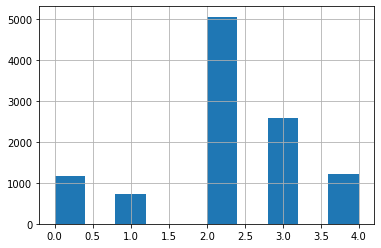

In [21]:
df[df['label']=='FAKE'].first_person_label.hist()

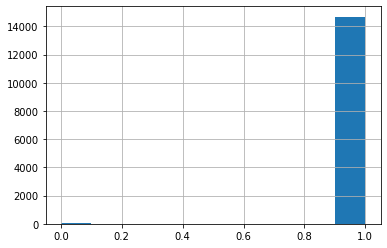

In [22]:
df.person_count.hist()

In [23]:
df.first_person_label.describe()

count    14691.000000
mean         1.593833
std          1.335319
min          0.000000
25%          0.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: first_person_label, dtype: float64

In [24]:
df = df.set_index('index')
df.head()

,label,split,isVal,cv_fold,person_count,first_person_label,second_person_label,first_person_frame_labels,second_person_frame_labels,original,version
index,,,,,,,,,,,
hrkquvytxp.mp4,FAKE,2nd_level,True,4,1,2.0,NaN,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",NaN,dqypurwdyr.mp4,2020-02-17
sacjkenugu.mp4,REAL,2nd_level,True,4,1,0.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
mquozjaiiw.mp4,REAL,2nd_level,True,2,1,0.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
kvvbxazeln.mp4,FAKE,2nd_level,True,1,1,3.0,NaN,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, ...",NaN,aigfuneurk.mp4,2020-02-17
lxkyjjvhox.mp4,FAKE,2nd_level,True,0,1,1.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",NaN,mjqtuozaey.mp4,2020-02-17


In [25]:
df_one_person = df[df['person_count']==1]
fake_real_ratio = len(df_one_person[df_one_person['label']=='FAKE']) / len(df_one_person[df_one_person['label']=='REAL'])
print('There are {0:.2} times more fakes'.format(fake_real_ratio))

There are 2.7 times more fakes


In [26]:
MISSING_VAL = 0.5

In [27]:
df.head()

,label,split,isVal,cv_fold,person_count,first_person_label,second_person_label,first_person_frame_labels,second_person_frame_labels,original,version
index,,,,,,,,,,,
hrkquvytxp.mp4,FAKE,2nd_level,True,4,1,2.0,NaN,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",NaN,dqypurwdyr.mp4,2020-02-17
sacjkenugu.mp4,REAL,2nd_level,True,4,1,0.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
mquozjaiiw.mp4,REAL,2nd_level,True,2,1,0.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
kvvbxazeln.mp4,FAKE,2nd_level,True,1,1,3.0,NaN,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, ...",NaN,aigfuneurk.mp4,2020-02-17
lxkyjjvhox.mp4,FAKE,2nd_level,True,0,1,1.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",NaN,mjqtuozaey.mp4,2020-02-17


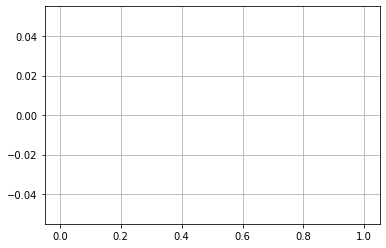

In [28]:
df[df['label']=='REAL'].second_person_label.hist()

In [29]:
from tqdm.notebook import tqdm as tqdm
import random
random.seed(2020)

subsample = 1000

#raw lists
preds_fake = []
preds_real = []

split_fake = []
split_real = []

keys=df.index.values
feat_len = featNames.shape[0]

for i, filename in enumerate(tqdm(filenames)):#[:subsample])):
    if i%500==0: # all garbage is not handled right
        gc.collect()
        
    plain_name = str(filename).split('/')[len(str(filename).split('/'))-1]
    if plain_name not in keys:
        continue
    is_fake = True if df.at[plain_name,'label'] == 'FAKE' else False
    
    #sample fakes the same amount as reals and sample randomly
    if is_fake and random.randint(0,int(round(10*fake_real_ratio))) >= 10:
        continue
    
    split = df.at[plain_name,'cv_fold']
    try:
        preds = deepFakeDetector.GetFeatures(str(filename), p_random_compression=(i%2==0))
    except:
        print("Error with " + str(filename) + ' - ' + str(i))
        if is_fake:
            preds_fake.append(np.ones(feat_len,np.float32)*MISSING_VAL)
            split_fake.append(split)
        else:
            preds_real.append(np.ones(feat_len,np.float32)*MISSING_VAL)
            split_real.append(split)
        continue
        
    def _addPred(preds, split, is_fake):
        if is_fake:
            preds_fake.append(preds)
            split_fake.append(split)
        else:
            preds_real.append(preds)
            split_real.append(split)
    
    # preds can have two persons
    if len(preds) > 1:
        continue # skip for now
        # include both
        first_label = df.loc[plain_name]['first_person_label']
        second_label = df.loc[plain_name]['second_person_label']
        if first_label == 0:
            _addPred(preds[0], split, False)
        elif first_label > 0:
            _addPred(preds[0], split, True)
            
        # this assumes the face order is the same
        if second_label == 0:
            _addPred(preds[1], split, False)
        elif second_label > 0:
            _addPred(preds[1], split, True)
    else:
        _addPred(preds[0], split, is_fake)

Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_20/tmgmtwznkr.mp4 - 47419
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_20/xfvjsztftm.mp4 - 47739
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_26/izjwmhunbk.mp4 - 61225
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_30/xhjzkecikh.mp4 - 71952
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_32/eiatoypqys.mp4 - 74888
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_32/evpmcvhcpz.mp4 - 74946
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_32/jswhgnskzt.mp4 - 75381
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_32/uegsvqxklf.mp4 - 76330
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_43/pjofjddsnu.mp4 - 102941
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_45/cdxktalois.mp4 - 106822
Error with /mnt/945C2D6E5C2D4BF4/Kaggl

Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_47/sowmxypmbs.mp4 - 112859
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_47/tdlzglwrpb.mp4 - 112906
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_47/uhswpjqirh.mp4 - 113014
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_47/urpjyivumo.mp4 - 113041
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_47/uuzhgdmkoy.mp4 - 113051
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_47/uzabmrkzvk.mp4 - 113070
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_47/vvxnfaqbot.mp4 - 113141
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_47/wnkqpydjck.mp4 - 113209
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_47/wtiscahftt.mp4 - 113234
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_47/wujzgtmhve.mp4 - 113238
Error with /mnt/945C2D6E5C2D4B

Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/wofnyginsw.mp4 - 118728
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/ynhpdkhtqp.mp4 - 118958
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/zcqpuoxinz.mp4 - 119032
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/zctcyovstn.mp4 - 119033
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/zgnsapfgua.mp4 - 119045
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/zitaceokgz.mp4 - 119055
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/zswrzqggzw.mp4 - 119117
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/zwwiltbegv.mp4 - 119131



In [30]:
# is the set balanced?
print(len(preds_real), len(preds_fake))

3949 3709


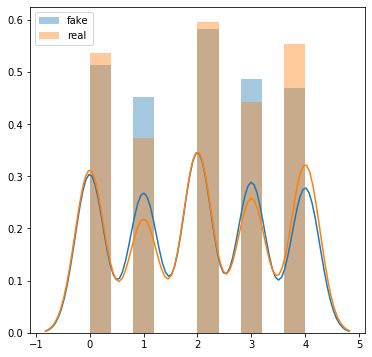

In [31]:
# are the splits balanced?
f, ax = plt.subplots(1,1,figsize=(6,6))
sns.distplot(split_fake,bins=10, ax=ax, label='fake')
sns.distplot(split_real,bins=10, ax=ax, label='real')
ax.legend()

# Plot distributions for each feature

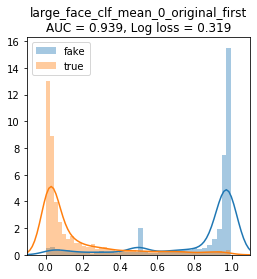

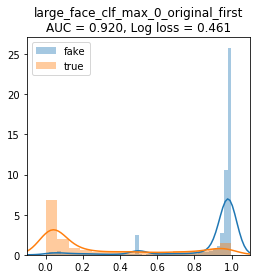

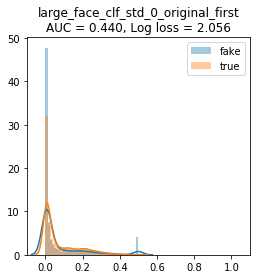

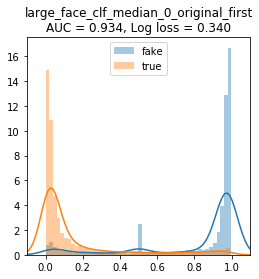

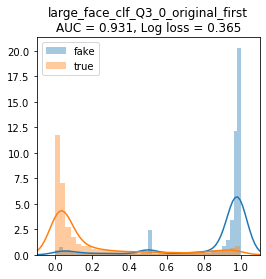

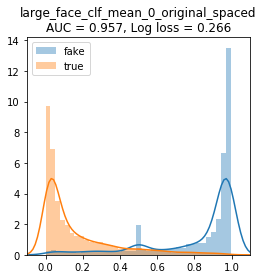

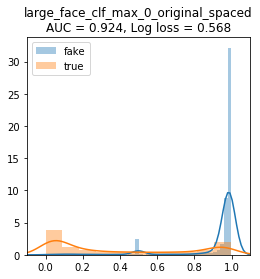

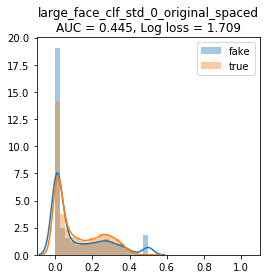

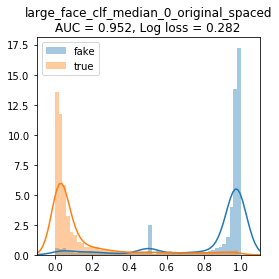

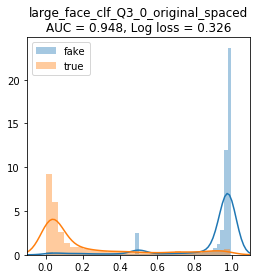

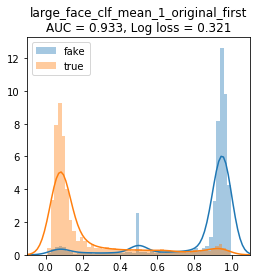

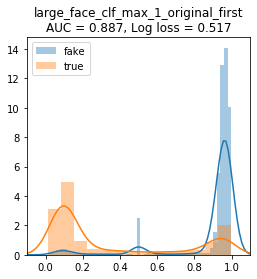

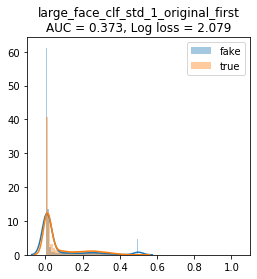

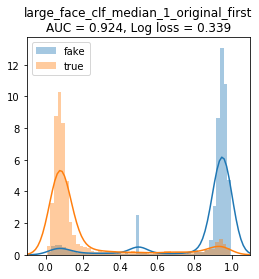

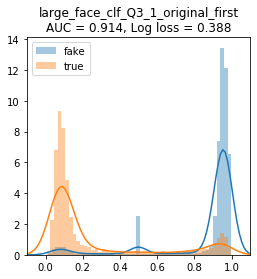

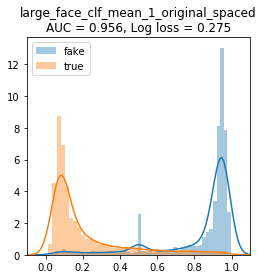

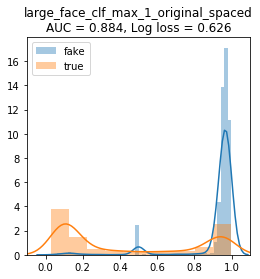

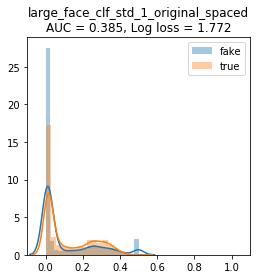

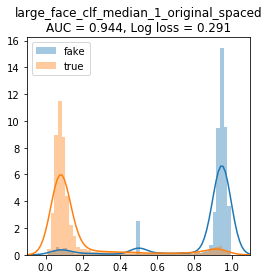

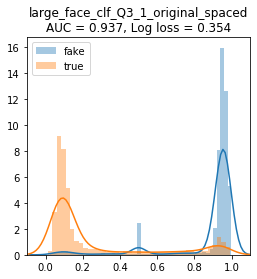

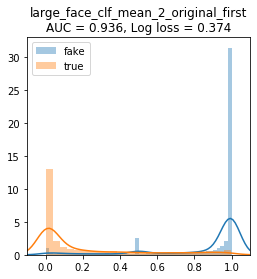

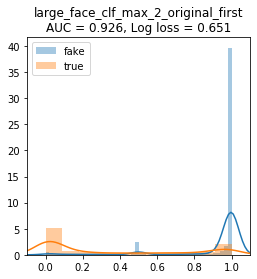

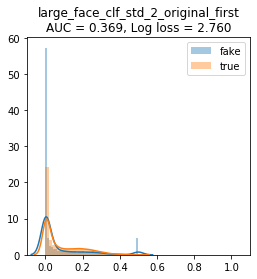

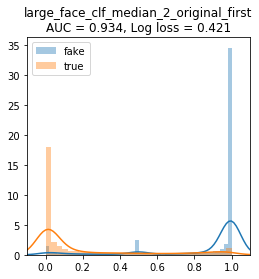

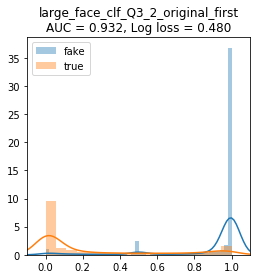

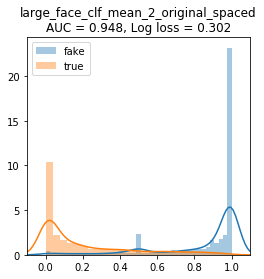

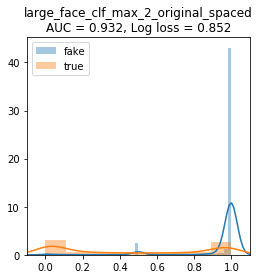

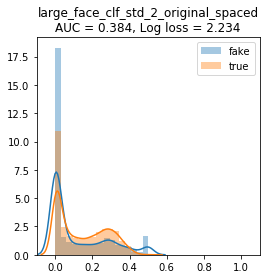

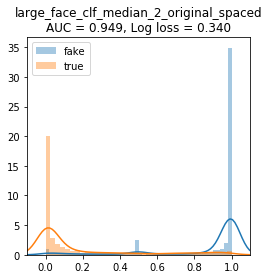

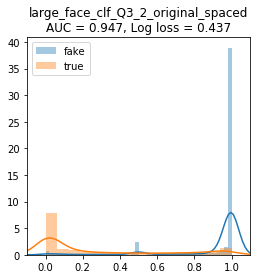

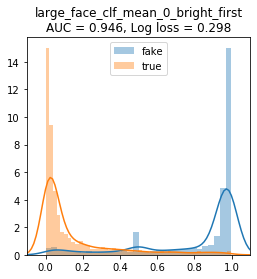

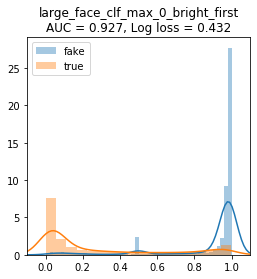

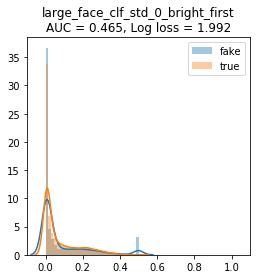

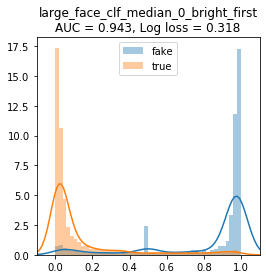

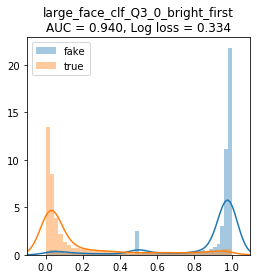

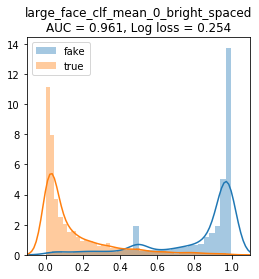

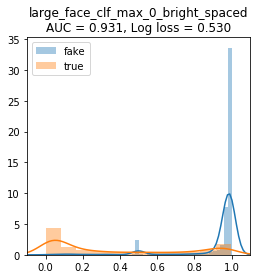

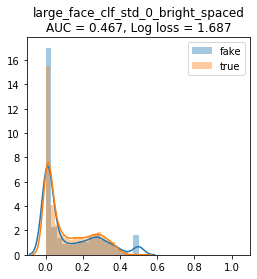

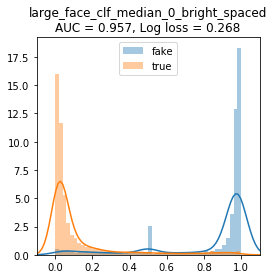

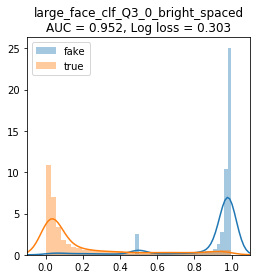

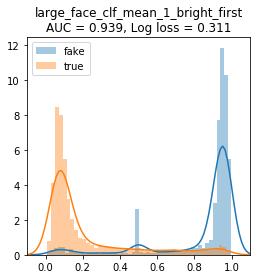

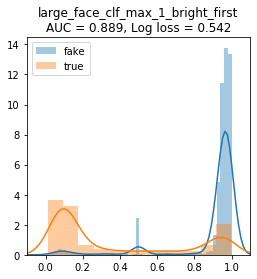

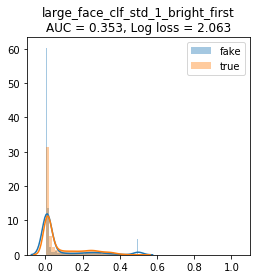

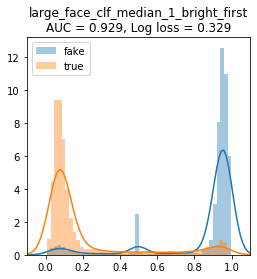

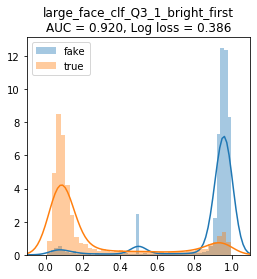

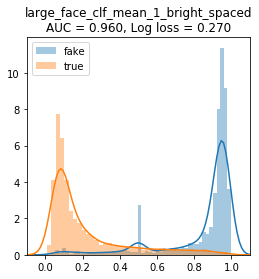

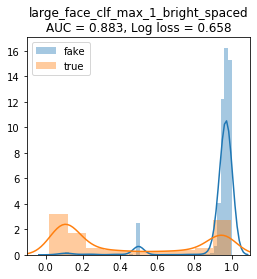

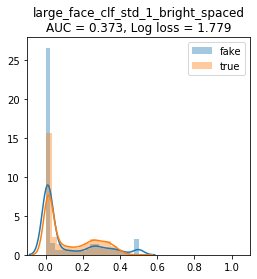

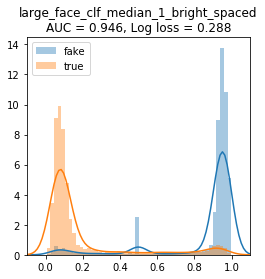

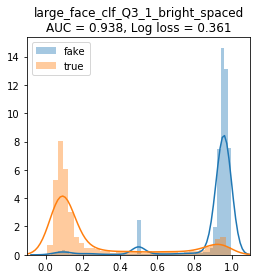

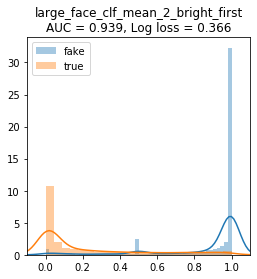

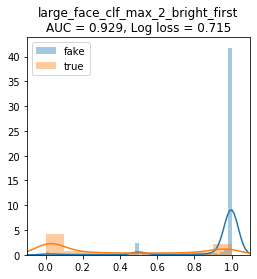

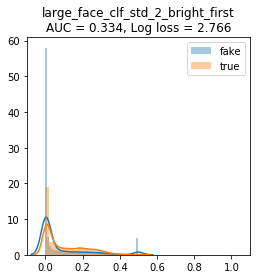

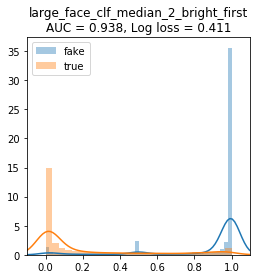

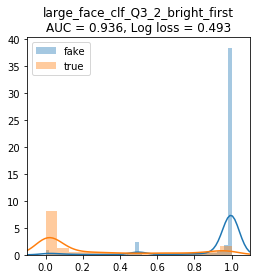

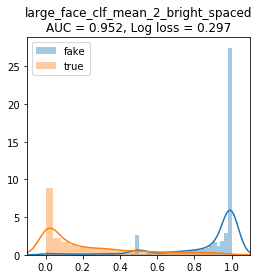

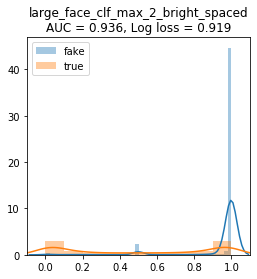

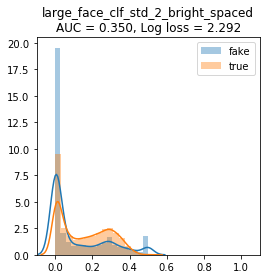

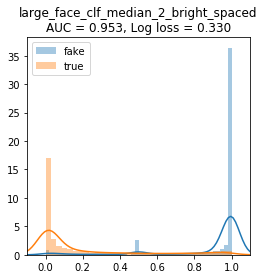

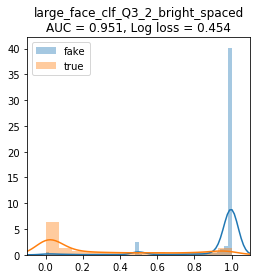

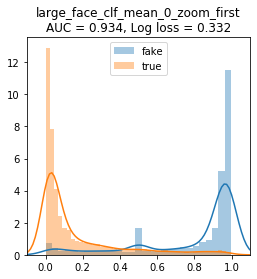

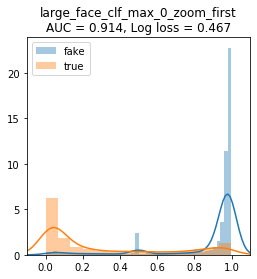

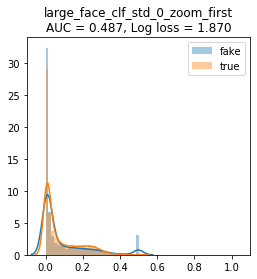

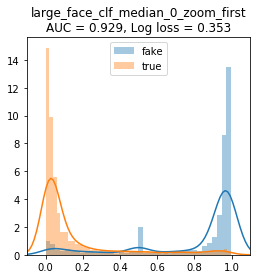

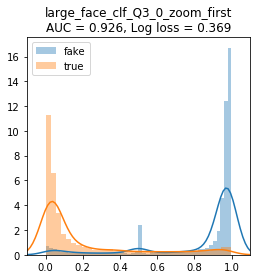

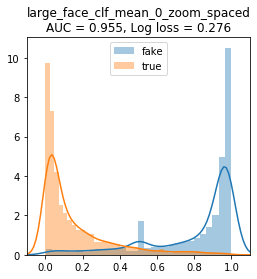

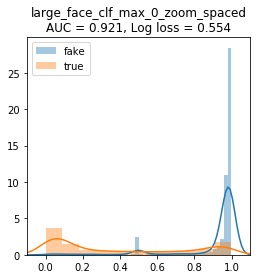

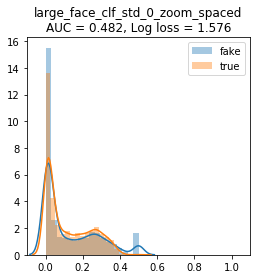

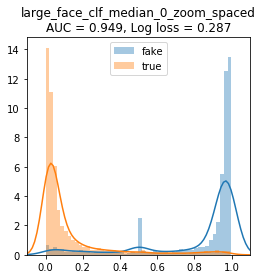

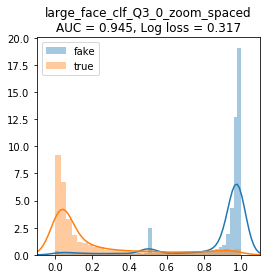

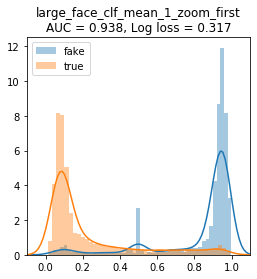

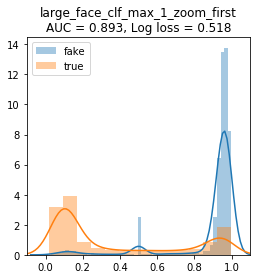

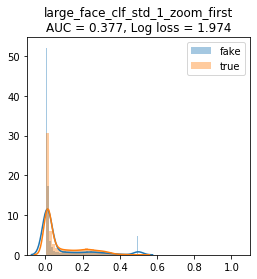

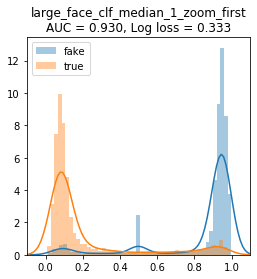

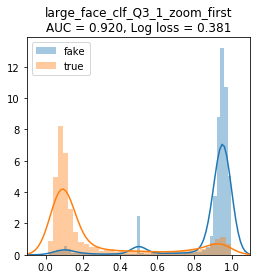

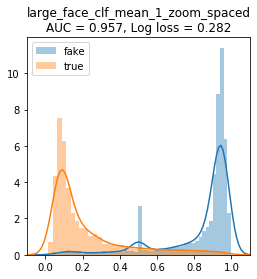

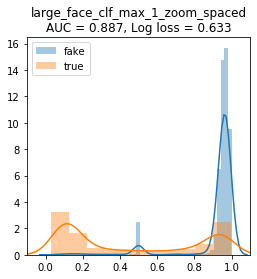

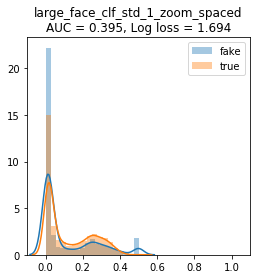

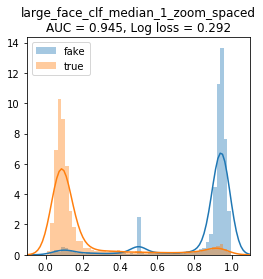

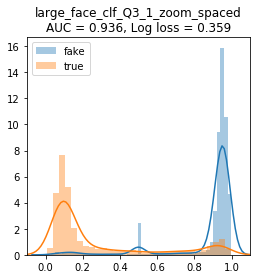

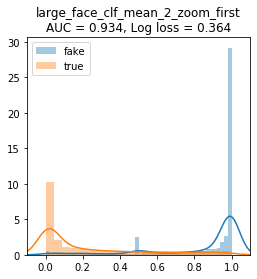

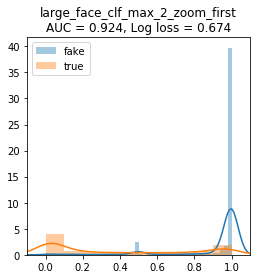

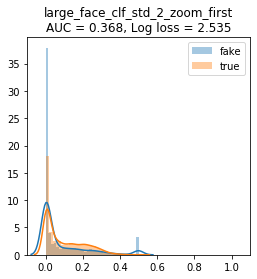

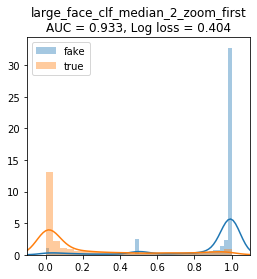

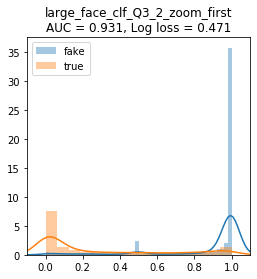

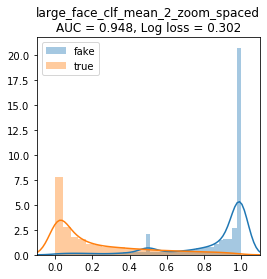

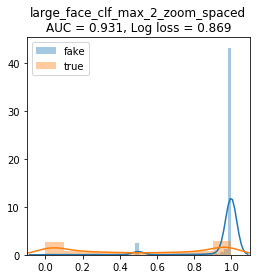

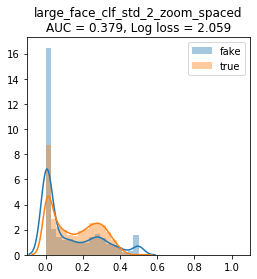

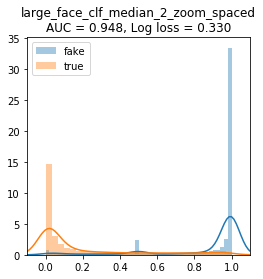

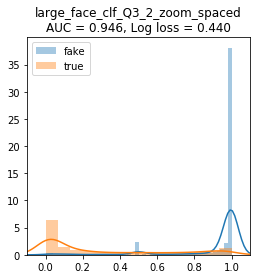

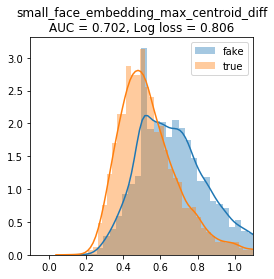

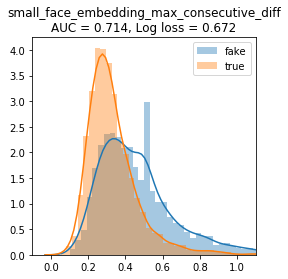

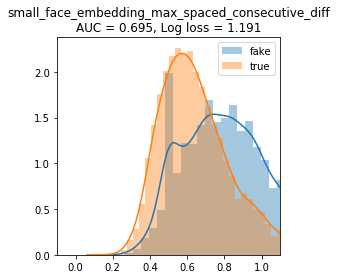

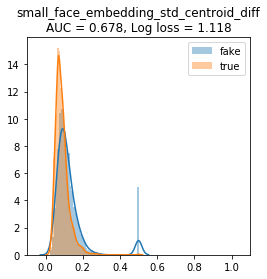

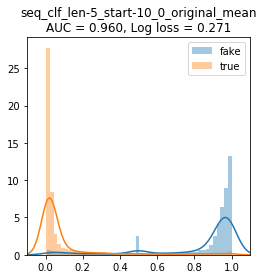

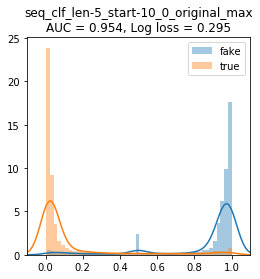

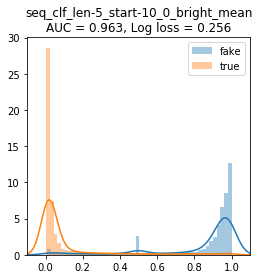

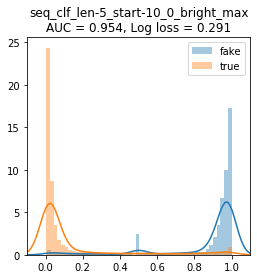

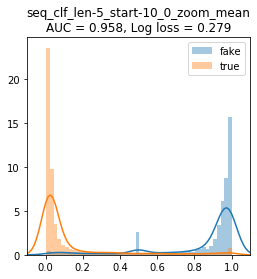

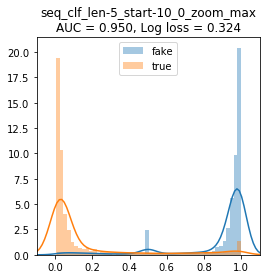

In [32]:
import matplotlib.axes
from sklearn.metrics import roc_auc_score, log_loss

def getAuc(fake_list, real_list):
    true_labels = np.concatenate([np.ones(len(fake_list)), np.zeros(len(real_list))])
    pred_labels = np.array(fake_list + real_list)
    return roc_auc_score(true_labels,pred_labels)

def getLogLoss(fake_list, real_list, eps=1e-6):
    true_labels = np.concatenate([np.ones(len(fake_list)), np.zeros(len(real_list))])
    pred_labels = np.array(fake_list + real_list)
    # epsilon clip to avoid nans
    pred_labels = np.clip(pred_labels,eps,1-eps)
    return log_loss(true_labels,pred_labels)

def plotFakeReal(feature_index):
    fake_list = list(np.array(preds_fake)[:,feature_index])
    real_list = list(np.array(preds_real)[:,feature_index])
    auc = getAuc(fake_list, real_list)
    logloss = getLogLoss(fake_list, real_list)
    f, ax = plt.subplots(1,1,figsize=(4,4))
    sns.distplot(fake_list, ax=ax, label='fake')
    sns.distplot(real_list, ax=ax, label='true')
    ax.set_title(featNames[feature_index] + '\n' + 'AUC = {0:.3f}, Log loss = {1:.3f}'.format(auc,logloss))
    ax.set_xlim(-0.1,1.1)
    #ax.set_ylim(0,5)
    ax.legend()
    plt.show()

for i in range(preds_fake[0].shape[0]):
    plotFakeReal(i)

# Feature classifier from XGBoost

In [33]:
# collect vectors
ys = np.concatenate([np.ones(len(preds_fake)), np.zeros(len(preds_real))])
xs_fake = np.array(preds_fake)
xs_real = np.array(preds_real)
xs = np.concatenate([xs_fake, xs_real], axis=0)
splits = np.concatenate([split_fake, split_real])
print(ys.shape)
print(xs.shape)
print(splits.shape)

(7658,)
(7658, 100)
(7658,)


In [34]:
# save for later
np.save("./saved_val_xs.npy", xs)
np.save("./saved_val_ys.npy", ys)
np.save("./saved_val_splits.npy", splits)

# Checkpoint

In [26]:
xs = np.load("./saved_val_xs.npy")
ys = np.load("./saved_val_ys.npy")
splits = np.load("./saved_val_splits.npy")

In [35]:
np.unique(splits, return_counts=True)

(array([0, 1, 2, 3, 4]), array([1606, 1259, 1804, 1419, 1570]))

In [36]:
def getSplitParts(fold=0, removeMissing=False):
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    for x,y,f in zip(xs,ys,splits):
        if(removeMissing and x[0]==MISSING_VAL):
            continue
        if f==999: # error cases
            continue
        if f==fold:
            X_test.append(x)
            y_test.append(y)
        else:
            X_train.append(x)
            y_train.append(y)
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [37]:
DIR_SECOND_LEVEL = '../models/second_level_models'
if not os.path.exists(DIR_SECOND_LEVEL):
    os.mkdir(DIR_SECOND_LEVEL)
DIR_EXPERIMENT = os.path.join(DIR_SECOND_LEVEL, '2020_03_19')
if not os.path.isdir(DIR_EXPERIMENT):
    os.mkdir(DIR_EXPERIMENT)

In [38]:
from sklearn.metrics import log_loss
import xgboost as xgb

losses = []
train_losses = []
preds = []
preds_real = []
preds_fake = []
xgb_models = []
eps = 1e-6
for fold in [0,1,2,3,4]:
    X_train, X_test, y_train, y_test = getSplitParts(fold, removeMissing=True)
    eval_set = [(X_train, y_train), (X_test, y_test)]
    eval_metric = "logloss"
    
    model = xgb.XGBClassifier(objective='reg:squarederror',#'binary:logistic', 
                             learning_rate = 0.1, 
                             max_depth = 4,
                             gamma=3,
                             subsample = 0.8,
                             colsample_bytree = 1,
                             reg_lambda=1,
                             reg_alpha=0.3,
                             alpha = 10, 
                             n_estimators = 40,
                             missing=MISSING_VAL)
    model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=False)
    model.save_model(str(os.path.join(DIR_EXPERIMENT,'second_level_xgb_{0}.bin'.format(fold))))
    xgb_models.append(model)
    
    y_pred = np.clip(model.predict_proba(X_test)[:,1],eps,1-eps)
    y_pred_train = np.clip(model.predict_proba(X_train)[:,1],eps,1-eps)
    preds.append(np.array(y_pred))
    for i, test in enumerate(y_test):
        if test > 0.5:
            preds_fake.append(y_pred[i])
        else:
            preds_real.append(y_pred[i])
    
    loss = log_loss(y_test.astype(np.float32),y_pred)
    loss_train = log_loss(y_train.astype(np.float32),y_pred_train)
    losses.append(loss)
    train_losses.append(loss_train)
    print("Fold {0} train_loss: {1:.3f}, val_loss: {2:.3f}".format(fold,loss_train,loss))

print('')
print("Mean train_loss {0:.3f}, val_loss {1:.3f}".format(np.mean(np.array(train_losses)),np.mean(np.array(losses))))
print("train loss std {0:.3f}, val loss std {1:.3f}".format(np.std(np.array(train_losses)),np.std(np.array(losses))))

Fold 0 train_loss: 0.133, val_loss: 0.254
Fold 1 train_loss: 0.140, val_loss: 0.195
Fold 2 train_loss: 0.143, val_loss: 0.179
Fold 3 train_loss: 0.141, val_loss: 0.209
Fold 4 train_loss: 0.154, val_loss: 0.127

Mean train_loss 0.142, val_loss 0.193
train loss std 0.007, val loss std 0.041


In [39]:
y_pred

array([0.982455, 0.982455, 0.969676, 0.982455, ..., 0.02412 , 0.02412 , 0.02412 , 0.039977], dtype=float32)

Text(0.5, 1.0, 'Mean loss: 0.193')

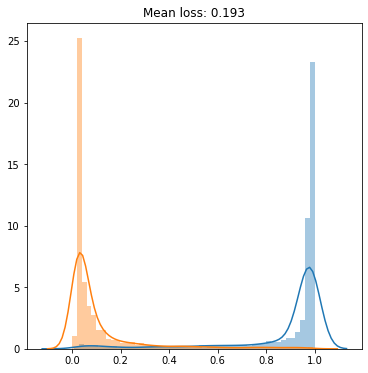

In [40]:
f, ax = plt.subplots(1,1,figsize=(6,6))
sns.distplot(preds_fake, ax=ax, label='fake')
sns.distplot(preds_real, ax=ax, label='true')
ax.set_title('Mean loss: {0:.3}'.format(np.mean(np.array(losses))))

## Weight analysis - eli5

In [41]:
for model in xgb_models:
    display(eli5.explain_weights_xgboost(model, feature_names=featNames))

Weight,Feature
0.3686,large_face_clf_median_1_bright_spaced
0.1504,large_face_clf_Q3_1_bright_spaced
0.1331,large_face_clf_Q3_1_zoom_spaced
0.0721,large_face_clf_mean_0_zoom_spaced
0.0472,large_face_clf_median_0_zoom_spaced
0.0248,seq_clf_len-5_start-10_0_bright_mean
0.0123,large_face_clf_Q3_2_bright_spaced
0.0111,large_face_clf_median_1_bright_first
0.0109,large_face_clf_median_2_bright_first
0.0104,large_face_clf_mean_1_bright_first


Weight,Feature
0.5121,seq_clf_len-5_start-10_0_bright_max
0.1351,large_face_clf_median_1_bright_spaced
0.1024,seq_clf_len-5_start-10_0_bright_mean
0.0366,seq_clf_len-5_start-10_0_zoom_mean
0.0269,large_face_clf_mean_1_bright_spaced
0.0203,large_face_clf_median_1_bright_first
0.0166,large_face_clf_mean_0_bright_spaced
0.0129,large_face_clf_mean_1_bright_first
0.0106,large_face_clf_Q3_2_bright_spaced
0.0076,large_face_clf_mean_2_bright_first


Weight,Feature
0.4368,seq_clf_len-5_start-10_0_bright_max
0.1954,seq_clf_len-5_start-10_0_bright_mean
0.0581,seq_clf_len-5_start-10_0_zoom_mean
0.0476,large_face_clf_median_1_bright_spaced
0.0232,large_face_clf_mean_0_original_spaced
0.0209,large_face_clf_Q3_2_bright_spaced
0.0196,large_face_clf_median_1_bright_first
0.0147,large_face_clf_mean_0_zoom_spaced
0.0116,large_face_clf_max_1_bright_first
0.0114,large_face_clf_median_0_bright_first


Weight,Feature
0.3526,seq_clf_len-5_start-10_0_bright_mean
0.2360,large_face_clf_median_1_bright_spaced
0.0497,large_face_clf_Q3_2_bright_spaced
0.0404,seq_clf_len-5_start-10_0_zoom_mean
0.0257,large_face_clf_mean_0_bright_spaced
0.0251,large_face_clf_median_1_bright_first
0.0202,large_face_clf_mean_1_bright_first
0.0182,large_face_clf_mean_2_bright_first
0.0159,large_face_clf_max_1_bright_first
0.0112,large_face_clf_mean_2_bright_spaced


Weight,Feature
0.3657,seq_clf_len-5_start-10_0_bright_mean
0.1785,large_face_clf_median_1_bright_spaced
0.1032,large_face_clf_Q3_2_bright_spaced
0.0352,large_face_clf_max_2_bright_spaced
0.0275,large_face_clf_Q3_2_original_spaced
0.0257,large_face_clf_median_1_bright_first
0.0201,seq_clf_len-5_start-10_0_zoom_mean
0.0166,large_face_clf_mean_0_zoom_spaced
0.0161,large_face_clf_mean_1_bright_spaced
0.0137,large_face_clf_median_0_bright_first


In [42]:
pd.DataFrame({'Variable':featNames,
              'Importance':model.feature_importances_}).sort_values('Importance', ascending=False)

,Variable,Importance
96,seq_clf_len-5_start-10_0_bright_mean,0.365666
48,large_face_clf_median_1_bright_spaced,0.178465
59,large_face_clf_Q3_2_bright_spaced,0.103190
56,large_face_clf_max_2_bright_spaced,0.035224
29,large_face_clf_Q3_2_original_spaced,0.027462
...,...,...
67,large_face_clf_std_0_zoom_spaced,0.000000
68,large_face_clf_median_0_zoom_spaced,0.000000
42,large_face_clf_std_1_bright_first,0.000000
41,large_face_clf_max_1_bright_first,0.000000


## Logistic regression

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.externals import joblib
import pickle

In [44]:
losses = []
train_losses = []
preds = []
preds_real = []
preds_fake = []
lr_models = []
for fold in [0,1,2,3,4]:
    X_train, X_test, y_train, y_test = getSplitParts(fold, removeMissing=True)
    
    clf = LogisticRegression(random_state=0, 
                             max_iter=1000,
                             solver='lbfgs').fit(X_train, y_train)

    filename = str(os.path.join(DIR_EXPERIMENT,'second_level_LogReg_{0}.sav'.format(fold)))
    #pickle.dump(clf, open(filename, 'wb'))
    #clf = pickle.load(open(filename,'rb'))
    joblib.dump(clf, filename)
    clf = joblib.load(filename)
    lr_models.append(clf)
    
    y_pred = np.clip(clf.predict_proba(X_test)[:,1],eps, 1-eps)
    y_pred_train = np.clip(clf.predict_proba(X_train)[:,1],eps, 1-eps)
    #y_pred = np.clip(y_pred,0.4,1.0)
    preds.append(np.array(y_pred))
    for i, test in enumerate(y_test):
        if test > 0.5:
            preds_fake.append(y_pred[i])
        else:
            preds_real.append(y_pred[i])
    
    loss = log_loss(y_test.astype(np.float32),y_pred)
    loss_train = log_loss(y_train.astype(np.float32),y_pred_train)
    losses.append(loss)
    train_losses.append(loss_train)
    print("Fold {0} train_loss: {1:.3f}, val_loss: {2:.3f}".format(fold,loss_train,loss))

print('')
print("Mean train_loss {0:.3f}, val_loss {1:.3f}".format(np.mean(np.array(train_losses)),np.mean(np.array(losses))))
print("train loss std {0:.3f}, val loss std {1:.3f}".format(np.std(np.array(train_losses)),np.std(np.array(losses))))

Fold 0 train_loss: 0.146, val_loss: 0.262
Fold 1 train_loss: 0.155, val_loss: 0.199
Fold 2 train_loss: 0.159, val_loss: 0.181
Fold 3 train_loss: 0.150, val_loss: 0.227
Fold 4 train_loss: 0.174, val_loss: 0.115

Mean train_loss 0.157, val_loss 0.197
train loss std 0.010, val loss std 0.049


Text(0.5, 1.0, 'Mean loss: 0.197')

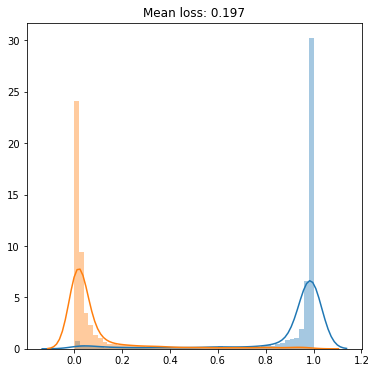

In [45]:
f, ax = plt.subplots(1,1,figsize=(6,6))
sns.distplot(preds_fake, ax=ax, label='fake')
sns.distplot(preds_real, ax=ax, label='true')
ax.set_title('Mean loss: {0:.3}'.format(np.mean(np.array(losses))))

In [46]:
for clf in lr_models:
    display(eli5.explain_weights_sklearn(clf,feature_names=featNames))

Weight?,Feature
+2.866,small_face_embedding_max_consecutive_diff
+1.575,small_face_embedding_max_spaced_consecutive_diff
+1.569,large_face_clf_max_0_bright_spaced
+1.453,large_face_clf_mean_2_bright_spaced
+1.290,large_face_clf_median_2_bright_spaced
+1.279,large_face_clf_median_0_zoom_spaced
+1.214,large_face_clf_mean_2_bright_first
+1.200,seq_clf_len-5_start-10_0_zoom_max
+1.184,large_face_clf_std_1_zoom_spaced
+1.107,large_face_clf_max_2_zoom_spaced


Weight?,Feature
+2.928,small_face_embedding_max_consecutive_diff
+2.109,small_face_embedding_max_spaced_consecutive_diff
+1.682,large_face_clf_mean_0_bright_spaced
+1.569,seq_clf_len-5_start-10_0_zoom_mean
+1.550,seq_clf_len-5_start-10_0_bright_mean
+1.525,large_face_clf_max_0_bright_spaced
+1.286,large_face_clf_max_2_zoom_first
+1.172,large_face_clf_median_1_bright_first
+1.140,large_face_clf_mean_0_original_spaced
+1.138,large_face_clf_mean_0_bright_first


Weight?,Feature
+3.071,small_face_embedding_max_consecutive_diff
+2.101,small_face_embedding_max_spaced_consecutive_diff
+1.899,large_face_clf_max_0_bright_spaced
+1.858,large_face_clf_mean_2_original_spaced
+1.673,large_face_clf_mean_0_original_spaced
+1.373,large_face_clf_mean_1_bright_spaced
+1.355,large_face_clf_mean_0_bright_spaced
+1.267,seq_clf_len-5_start-10_0_bright_mean
+1.140,large_face_clf_mean_0_zoom_spaced
+1.042,large_face_clf_mean_1_bright_first


Weight?,Feature
+3.036,small_face_embedding_max_consecutive_diff
+1.614,large_face_clf_max_0_bright_spaced
+1.610,seq_clf_len-5_start-10_0_zoom_mean
+1.364,large_face_clf_mean_2_original_spaced
+1.303,seq_clf_len-5_start-10_0_zoom_max
+1.264,small_face_embedding_max_spaced_consecutive_diff
+1.212,large_face_clf_Q3_0_bright_first
+1.174,small_face_embedding_max_centroid_diff
+1.165,large_face_clf_mean_1_bright_spaced
+1.155,large_face_clf_Q3_1_bright_spaced


Weight?,Feature
+2.753,small_face_embedding_max_consecutive_diff
+2.138,small_face_embedding_max_spaced_consecutive_diff
+1.766,seq_clf_len-5_start-10_0_zoom_mean
+1.731,large_face_clf_max_0_bright_spaced
+1.684,large_face_clf_mean_2_original_spaced
+1.338,large_face_clf_std_1_zoom_spaced
+1.336,large_face_clf_mean_0_bright_spaced
+1.194,large_face_clf_mean_1_bright_spaced
+1.147,large_face_clf_mean_0_original_spaced
+1.129,large_face_clf_mean_2_bright_spaced
